# Introdução às Redes Neurais Fisicamente Informadas - PINNs (Dia 05) Picture1.jpg

---
**EXEMPLO 4**

**Objetivo:** resolver o problema de valor inicial dado pela equação diferencial ordinária de 1a ordem $$y'(t)+3t^2 y(t)=6t^2$$ com condição inicial $y(0)=0$.

Esse PVI tem solução dada por $y(t)=2-2e^{-t^3}$ que pode ser obtida pelo método do fator integrante.


---
Diferentemente de todos os outros notebooks que trabalhamos, neste começamos instalando a biblioteca DeepXDE, pois ela não é parte do Google Colab.

In [ ]:
!pip install deepxde -q gwpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


---
E em seguida importando o necessário, perceba que estamos agora importando o DeepXDE como `dde`

O DeepXDE aceita várias APIs de aprendizado de máquina como backend, aqui estou usando a padrão que é o `tensorflow`. Mas ele aceita `jax`, `pytorch` e `paddle` também.

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


---
**1$^\mathrm{a}$ Etapa**

A primeira parte do nosso processo de solução no DeepXDE é definir a equação diferencial a se trabalhar.

O problema de valor inicial é dado pela equação $y'(t)+3t^2 y(t)=6t^2$ e condição inicial $y(0)=0$.

Começamos definindo a função `ode` com duas entradas: (1) a variável independente `t` e (2) a variável dependente `y`.

Para escrevemos a equação diferencial precisamos da derivada da variável dependente. No DeepXDE a 1$^\mathrm{a}$ derivada é calculada utilizando o comando `dde.grad.jacobian(y, t)`.

Por fim retornamos a equação na forma $y'+3t^2 y-6t^2,$ uma vez que o objetivo da rede é minimizar este termo de forma que ele esteja próximo de zero.

In [ ]:
def ode(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    return dy_dt + 3 * t**2 * y - 6 * t**2

---
**2$^\mathrm{a}$ Etapa**

Vamos agora definir a geometria do nosso domínio e a condição inicial.

Como estamos lidando com uma EDO, nossa geometria será um intervalo na reta $\mathbb{R}$. Fazemos essa definição utilizando o comando `dde.geometry.TimeDomain(a, b)`.

Em seguida, como estamos lidando com uma condição inicial à esquerda (o usual) vamos definir uma função `boundary_l` que retorna o ponto na fronteira $t=a$.

Finalmente utilizando o módulo de condições iniciais e de fronteira do DeepXDE chamamos a função `dde.icbc.IC(...)` cujas entradas são: (1) a geometria; (2) o valor da condição inicial e (3) qual ponto está a condição inicial.

In [ ]:
a = 0
b = 2
y_0 = 0

geom = dde.geometry.TimeDomain(a, b)

# define o limite à esquerda do intervalo
def boundary_l(t, on_initial):
    return on_initial and dde.utils.isclose(t[0], a)

ic1 = dde.icbc.IC(geom, lambda x: y_0, boundary_l)

---
**3$^\mathrm{a}$ Etapa**

Neste momento devemos montar a estrutura da nossa rede neural.

Primeiro passo é utilizar o método `TimePDE` para incluir as informações que definimos no passo anterior: (1) geometria; (2) equação diferencial; (3) condições iniciais e (4) a quantidade de pontos amostrados aleatoriamente no interior do domínio e na fronteira.

Em seguida devemos escolher os parâmetros da rede como: (1) número de camadas e neurônios, (2) função de ativação e (3) o inicializador dos pesos.

Por último compilamos o modelo para fazer a mágica acontecer.

In [ ]:
data = dde.data.TimePDE(geom, ode, ic1, num_domain=64, num_boundary=2)

layer_size = [1] + [50] * 4 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=False, isplot=False)

Compiling model...
Building feed-forward neural network...
'build' took 0.151374 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.858389 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.00e+02, 0.00e+00]    [2.00e+02, 0.00e+00]    []  
1000      [1.51e-01, 1.08e-02]    [1.51e-01, 1.08e-02]    []  
2000      [3.22e-03, 1.38e-06]    [3.22e-03, 1.38e-06]    []  
3000      [1.23e-03, 3.56e-07]    [1.23e-03, 3.56e-07]    []  
4000      [3.34e-04, 7.57e-08]    [3.34e-04, 7.57e-08]    []  
5000      [1.20e-04, 1.42e-08]    [1.20e-04, 1.42e-08]    []  
6000      [9.14e-05, 8.31e-09]    [9.14e-05, 8.31e-09]    []  
7000      [7.36e-05, 5.56e-09]    [7.36e-05, 5.56e-09]    []  
8000      [5.55e-05, 3.37e-09]    [5.55e-05, 3.37e-09]    []  
9000      [3.83e-05, 1.10e-09]    [3.83e-05, 1.10e-09]    []  
10000     [3.63e-05, 8.61e-09]    [3.63e-05, 8.61e-09]    []  

Best model at step 10000:
  train loss: 3.63e-05
  test loss: 3.63e-05
  test metric: []

'train' took 14.870329 s



---
**4$^\mathrm{a}$ Etapa**

Finalmente, após fazer os cálculos necessários, vamos verificar se a rede produziu a solução esperada comparando com a solução conhecida.

Aqui vamos utilizar a função `geom.uniform_points` para gerar a malha necessária para os gráficos e `model.predict` para gerar as imagens dos pontos da malha.

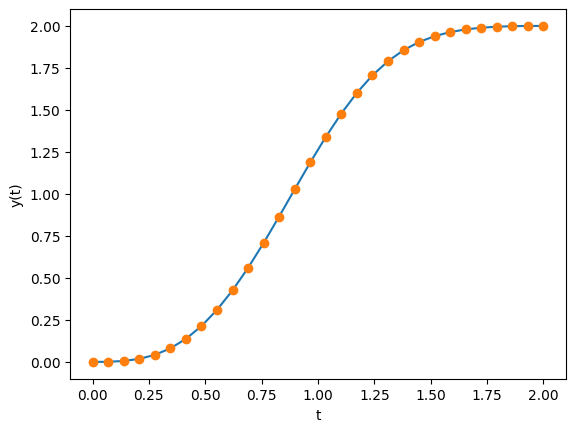

In [ ]:
def func(t):
     return 2 - 2 * np.exp(-t**3)

x = geom.uniform_points(30, True)
y = model.predict(x)
y_test = func(x)
plt.figure()
plt.plot(x, y,x,y_test,'o')
plt.xlabel("t")
plt.ylabel("y(t)")
plt.show()